In [1]:
%matplotlib inline

In [2]:
!pip install -r requirements.txt

In [3]:
%%sh 
if ! az account show ; then
    az login --tenant fdpo.onmicrosoft.com 
fi


sh: 1: [: {: unexpected operator


[
  {
    "cloudName": "AzureCloud",
    "homeTenantId": "16b3c013-d300-468d-ac64-7eda0820b6d3",
    "id": "95bc36f4-2bb8-479c-abf2-f70e831fc224",
    "isDefault": true,
    "managedByTenants": [
      {
        "tenantId": "2f4a9838-26b7-47ee-be60-ccc1fdec5953"
      }
    ],
    "name": "MCAPS-Hybrid-REQ-53059-2023-luvinton",
    "state": "Enabled",
    "tenantId": "16b3c013-d300-468d-ac64-7eda0820b6d3",
    "user": {
      "name": "luvinton@microsoft.com",
      "type": "user"
    }
  }
]


In [4]:
import dask
import fsspec
import h5netcdf
import matplotlib.pyplot as plt
import matplotlib
import netCDF4
import s3fs
import xarray as xr
from dask.distributed import Client, performance_report, PipInstall, WorkerPlugin
from dask_cloudprovider.azure import AzureVMCluster


In [5]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 18}
matplotlib.rc('font', **font)
era5_url = 's3://era5-pds/2010/01/data/air_temperature_at_2_metres.nc' #https://github.com/zflamig/dask-era5/blob/main/notebook/era5_fargate_dask.ipynb
years = ["2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019"]
months = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]
file_pattern = 's3://era5-pds/{year}/{month}/data/air_temperature_at_2_metres.nc'
cluster_spec = {
        'location': 'uksouth',
        'resource_group': 'mo_dev',
        'vnet': 'mo_dev',
        'security_group': 'mo_dev-default-nsg-uksouth',
        'n_workers': len(years)*len(months),
        'disk_size': 50
} #todo: load from yaml


In [6]:
from dask_cloudprovider.azure import AzureVMCluster
cluster = AzureVMCluster(**cluster_spec)

Creating scheduler instance
Assigned public IP
Network interface ready
Creating VM
Created VM dask-890e78e1-scheduler
Waiting for scheduler to run at 51.132.63.3:8786
Scheduler is running


/opt/conda/lib/python3.10/contextlib.py:142: UserWarning: Creating your cluster is taking a surprisingly long time. This is likely due to pending resources. Hang tight! 
  next(self.gen)


Creating worker instance
Creating worker instance
Creating worker instance
Creating worker instance
Creating worker instance
Creating worker instance
Creating worker instance
Creating worker instance
Creating worker instance
Creating worker instance
Creating worker instance
Creating worker instance
Creating worker instance
Creating worker instance
Creating worker instance
Creating worker instance
Creating worker instance
Creating worker instance
Creating worker instance
Creating worker instance
Creating worker instance
Creating worker instance
Creating worker instance
Creating worker instance
Creating worker instance
Creating worker instance
Creating worker instance
Creating worker instance
Creating worker instance
Creating worker instance
Creating worker instance
Creating worker instance
Creating worker instance
Creating worker instance
Creating worker instance
Creating worker instance
Creating worker instance
Creating worker instance
Creating worker instance
Creating worker instance


In [7]:
packages = []
with open('requirements.txt', 'r') as r_file:
    packages = [line for line in r_file]

worker_deps_plugin = PipInstall(packages=packages, pip_options=["--upgrade"])

In [18]:
env_vars = []
with open('.devcontainer/devcontainer.env', 'r') as env_file:
    env_vars = [line.split('=') for line in env_file]

class S3fsPlugin(WorkerPlugin):
    def setup(self, worker):
        global s3fs
        import s3fs
        import os
        for env_var in env_vars:
            os.environ[env_var[0]] = env_var[1]
            
s3fs_plugin = S3fsPlugin()

In [9]:
client = Client(cluster)
client.register_worker_plugin(worker_deps_plugin)
client.register_worker_plugin(s3fs_plugin)

/opt/conda/lib/python3.10/site-packages/distributed/client.py:1364: VersionMismatchWarning: Mismatched versions found

+---------+----------------+----------------+----------------+
| Package | Client         | Scheduler      | Workers        |
+---------+----------------+----------------+----------------+
| numpy   | 1.23.5         | 1.24.2         | 1.24.2         |
| python  | 3.10.9.final.0 | 3.8.16.final.0 | 3.8.16.final.0 |
+---------+----------------+----------------+----------------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/distributed/comm/core.py", line 292, in connect
  File "/opt/conda/lib/python3.8/site-packages/distributed/utils.py", line 1812, in wait_for
  File "/opt/conda/lib/python3.8/asyncio/tasks.py", line 501, in wait_for
asyncio.exceptions.TimeoutError

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_12900/2139359280.py", line 3, in <module>
    client.register_worker_plugin(s3fs_plugin)
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 4845, in register_worker_plugin
    return self.sync(
  File "/opt/conda/lib/python3.10/site-packages/distributed/utils.py", line 345, in sync
    return sync(
  File "/opt/conda/lib/python3.10/site-packages/distribu

In [10]:
ncfile = fsspec.open(era5_url)
ds = xr.open_dataset(ncfile.open())
ds.air_temperature_at_2_metres.encoding

{'chunksizes': (24, 100, 100),
 'fletcher32': False,
 'shuffle': True,
 'zlib': True,
 'complevel': 4,
 'source': '<File-like object S3FileSystem, era5-pds/2010/01/data/air_temperature_at_2_metres.nc>',
 'original_shape': (744, 721, 1440),
 'dtype': dtype('<f4'),
 '_FillValue': 9.96921e+36}

In [11]:
@dask.delayed
def s3open(path):
    fs = s3fs.S3FileSystem(anon=True, default_fill_cache=False)
    return fs.open(path)

files_mapper = [s3open(file_pattern.format(year=year,month=month)) for year in years for month in months]

In [12]:
%%time

ds = xr.open_mfdataset(files_mapper, engine='h5netcdf', chunks={'lon':200,'lat':200,'time0':720}, concat_dim='time0', combine='nested', coords='minimal', compat='override', parallel=True)


CPU times: user 12 s, sys: 7.11 s, total: 19.1 s
Wall time: 1min 13s


In [13]:
print('ds size in GB {:0.2f}\n'.format(ds.nbytes / 1e9))
ds.info

ds size in GB 364.00



<bound method Dataset.info of <xarray.Dataset>
Dimensions:                      (lon: 1440, lat: 721, time0: 87648)
Coordinates:
  * lon                          (lon) float32 0.0 0.25 0.5 ... 359.5 359.8
  * lat                          (lat) float32 90.0 89.75 89.5 ... -89.75 -90.0
  * time0                        (time0) datetime64[ns] 2010-01-01 ... 2019-1...
Data variables:
    air_temperature_at_2_metres  (time0, lat, lon) float32 dask.array<chunksize=(720, 200, 200), meta=np.ndarray>
Attributes:
    source:       Reanalysis
    institution:  ECMWF
    tilte:        ERA5 forecasts>

In [14]:
ds['air_temperature_at_2_metres'] = (ds.air_temperature_at_2_metres - 273.15) * 9.0 / 5.0 + 32.0
ds.air_temperature_at_2_metres.attrs['units'] = 'F'
# calculates the mean along the time dimension
temp_mean = ds['air_temperature_at_2_metres'].mean(dim='time0')

In [15]:
%%time

with performance_report(filename="dask-report.html"):
    temp_mean = temp_mean.compute()

CPU times: user 9.35 s, sys: 2.16 s, total: 11.5 s
Wall time: 9min 12s


Text(0.5, 1.0, '2010-2019 Mean 2-m Air Temperature')

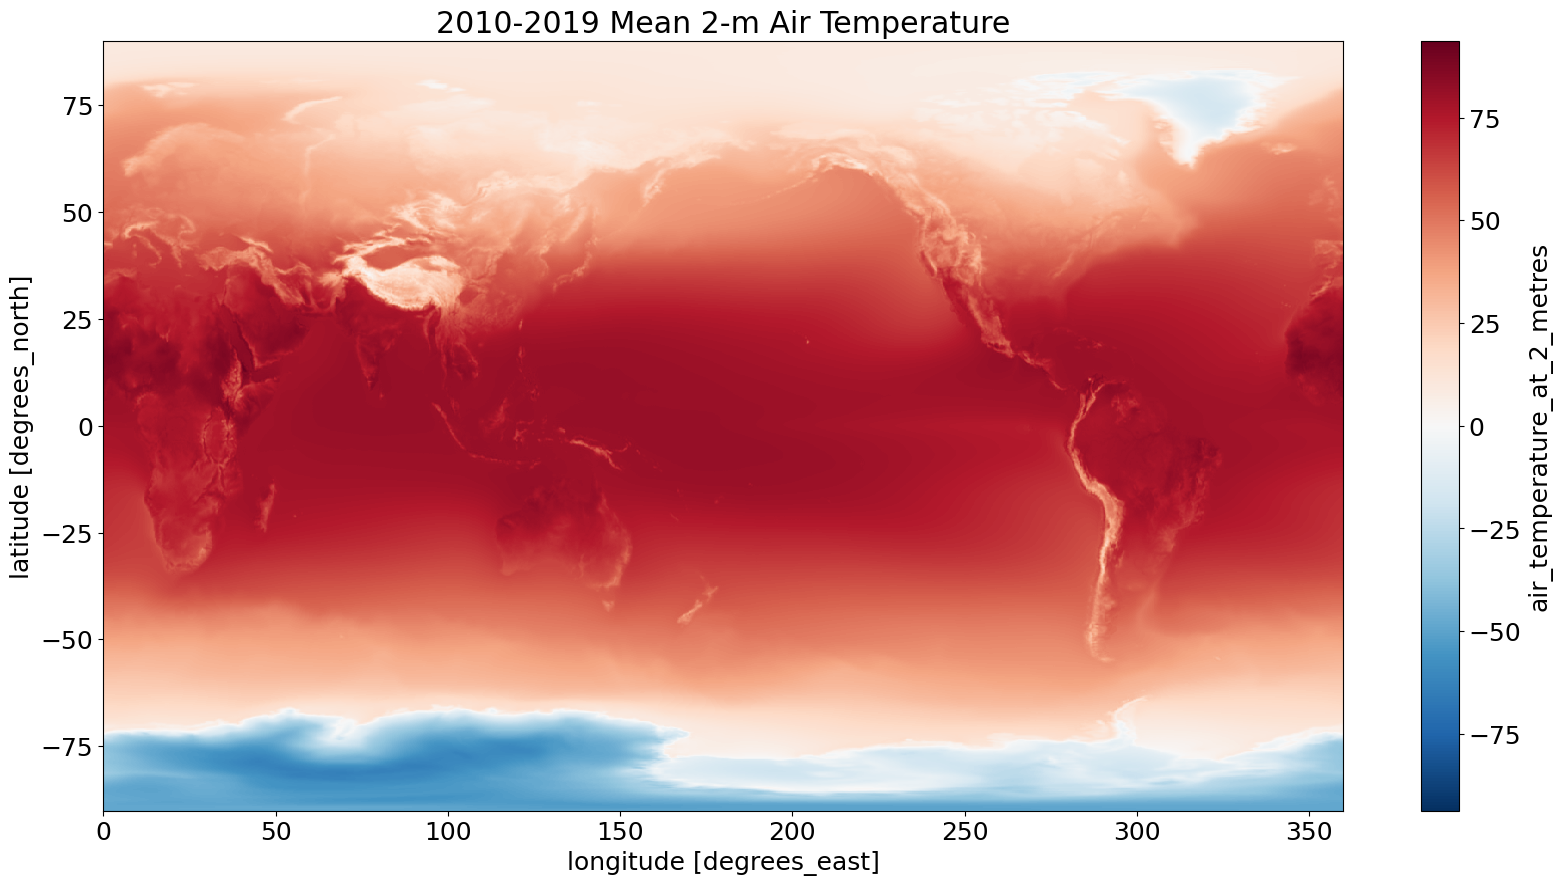

In [16]:
temp_mean.plot(figsize=(20, 10))
plt.title('2010-2019 Mean 2-m Air Temperature')

In [17]:
client.close()
cluster.close()

Terminated VM dask-890e78e1-worker-5bdbe56c
Terminated VM dask-890e78e1-worker-73dd4613
Terminated VM dask-890e78e1-worker-7c7e268c
Terminated VM dask-890e78e1-worker-2ac508b5
Terminated VM dask-890e78e1-worker-b4d6305b
Terminated VM dask-890e78e1-worker-8810b575
Terminated VM dask-890e78e1-worker-88247d82
Terminated VM dask-890e78e1-worker-93046142
Terminated VM dask-890e78e1-worker-98bf279f
Terminated VM dask-890e78e1-worker-84077a45
Terminated VM dask-890e78e1-worker-7522a021
Terminated VM dask-890e78e1-worker-3332d12d
Terminated VM dask-890e78e1-worker-38c99141
Terminated VM dask-890e78e1-worker-93135ae4
Terminated VM dask-890e78e1-worker-9448cac0
Terminated VM dask-890e78e1-worker-c5f83c4d
Terminated VM dask-890e78e1-worker-1db2914b
Terminated VM dask-890e78e1-worker-ed07deca
Terminated VM dask-890e78e1-worker-2c84fe72
Terminated VM dask-890e78e1-worker-2a5a9c92
Terminated VM dask-890e78e1-worker-c4603604
Terminated VM dask-890e78e1-worker-275d6d12
Terminated VM dask-890e78e1-work